In [14]:
import pandas as pd
import numpy as np
import spacy
from pprint import pprint
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotalt import show_with_alt, generate_alt_text

nlp = spacy.load("en_core_web_sm")
matplotlib.rcParams["figure.dpi"] = 200

In [2]:
combined_alt_texts_df = pd.read_json("./combined_stats.jsonl", lines=True, orient="records")
#print(combined_alt_texts_df.columns)
vistext_alt_lengths = defaultdict(list)
gallery_alt_lengths = defaultdict(list)

alt_types = ["human", "heuristic", 'gpt-4-turbo-L3',
             'gpt-4-turbo-alt-L3', 'gpt-4-turbo-table-L3',
             'gpt-4-turbo-table-alt-L3', 't5-imageguided-imageonly',
             't5-imageguided-datatable', 't5-imageguided-scenegraph']

for _, row in tqdm(combined_alt_texts_df.iterrows()):
    for alt_type in alt_types:
        alt_texts = row[alt_type]
        if alt_texts is not None:
            if isinstance(alt_texts, str):
                alt_texts = [alt_texts]
            for alt_text in alt_texts:
                alt_len = len([token.text for token in nlp(alt_text)])
                if row["dataset"] == "vistext":
                    vistext_alt_lengths[alt_type].append(alt_len)
                elif row["dataset"] == "gallery":
                    gallery_alt_lengths[alt_type].append(alt_len)

1084it [02:27,  7.34it/s]


Mean vistext alt lengths:
human: 90.00866141732284
heuristic: 92.80045351473923
gpt-4-turbo-L3: 165.48979591836735
gpt-4-turbo-alt-L3: 165.2338251986379
gpt-4-turbo-table-L3: 174.4971623155505
gpt-4-turbo-table-alt-L3: 173.05074971164936
t5-imageguided-imageonly: 75.02380952380952
t5-imageguided-datatable: 62.36621315192744
t5-imageguided-scenegraph: 64.87414965986395

Mean vistext alt lengths:
heuristic: 138.6138613861386
gpt-4-turbo-L3: 184.55940594059405
gpt-4-turbo-alt-L3: 175.9950495049505


C:\Users\Kai\AppData\Local\Temp\ipykernel_4924\2871899327.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(["VL-T5 datatable", "VL-T5 scenegraph", "VL-T5 imageonly", \
C:\Users\Kai\AppData\Local\Temp\ipykernel_4924\2871899327.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(["Heuristic", "turbo + heuristic", "turbo"])


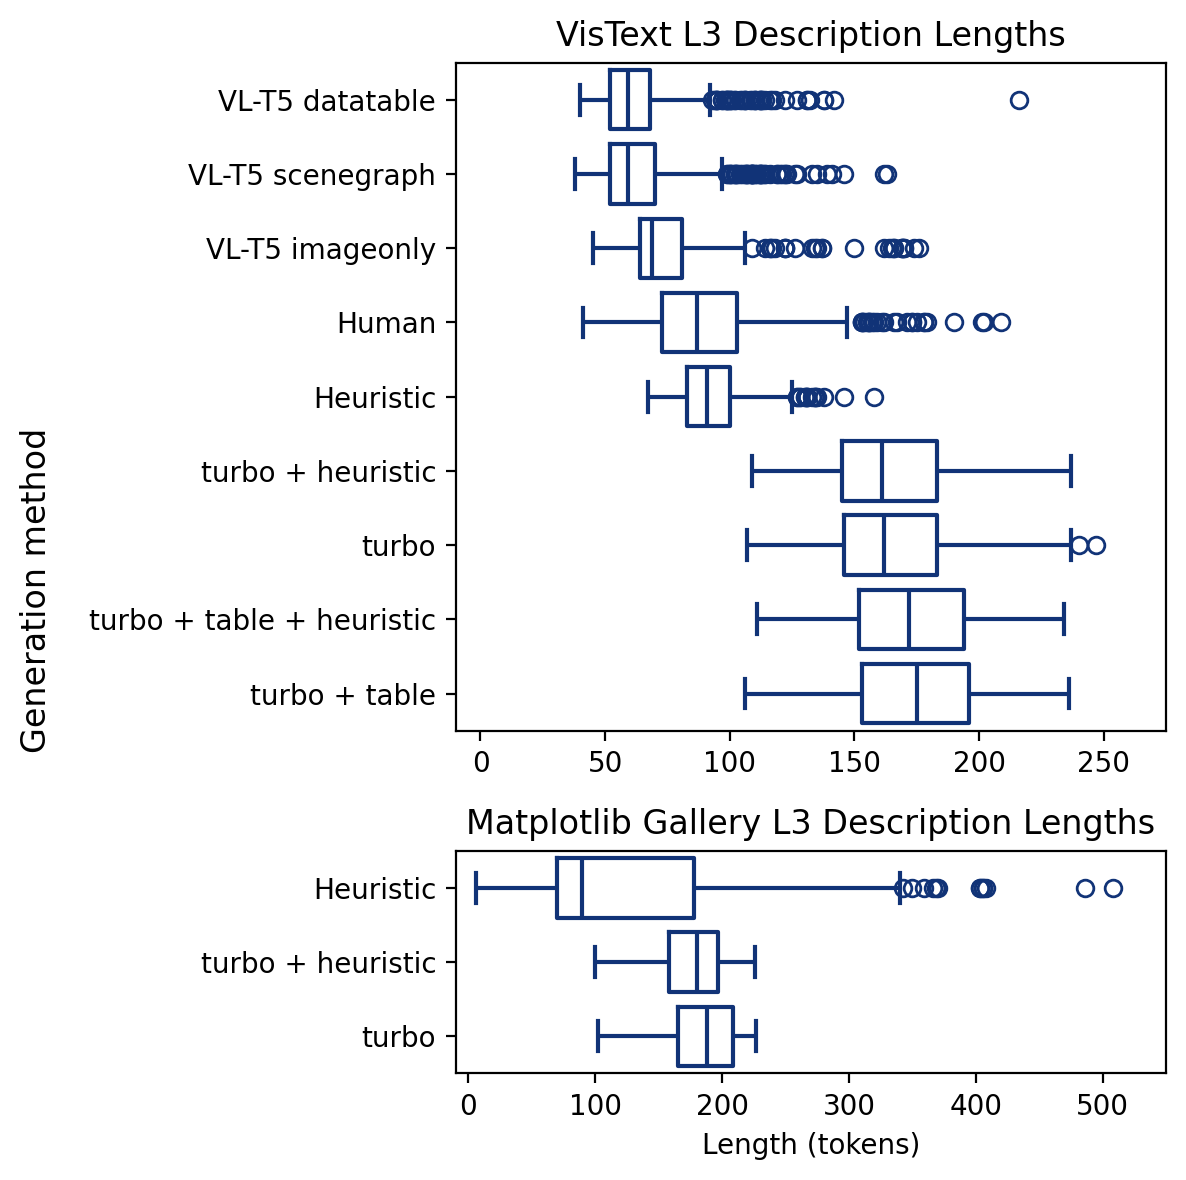

In [25]:
print("Mean vistext alt lengths:")
for alt_type, alt_lengths in vistext_alt_lengths.items():
    print(f"{alt_type}: {np.mean(alt_lengths)}")
print()
print("Mean vistext alt lengths:")
for alt_type, alt_lengths in gallery_alt_lengths.items():
    print(f"{alt_type}: {np.mean(alt_lengths)}")

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6, 6), height_ratios=[3, 1])
axs = axs.flatten()
sns.boxplot(vistext_alt_lengths, ax=axs[0], fill=False, color="#137", orient="h", order=["t5-imageguided-datatable", "t5-imageguided-scenegraph", "t5-imageguided-imageonly", "human", "heuristic", "gpt-4-turbo-alt-L3", "gpt-4-turbo-L3", "gpt-4-turbo-table-alt-L3", "gpt-4-turbo-table-L3"])
sns.boxplot(gallery_alt_lengths, ax=axs[1], fill=False, color="#137", orient="h", order=["heuristic", "gpt-4-turbo-alt-L3", "gpt-4-turbo-L3"])
axs[0].set_title("VisText L3 Description Lengths")
axs[1].set_title("Matplotlib Gallery L3 Description Lengths")
axs[0].set_xlim((-10, 275))
axs[1].set_xlim((-10, 550))

axs[0].set_yticklabels(["VL-T5 datatable", "VL-T5 scenegraph", "VL-T5 imageonly", \
                        "Human", "Heuristic", "turbo + heuristic", "turbo", "turbo + table + heuristic",
                        "turbo + table"])
axs[1].set_yticklabels(["Heuristic", "turbo + heuristic", "turbo"])
fig.supylabel("Generation method")
axs[1].set_xlabel("Length (tokens)")
plt.tight_layout()
#print()
#print(generate_alt_text())

In [17]:
gallery_errors = pd.read_csv("./gallery_error_annotations.tsv", sep='\t', header=0)
vistext_errors = pd.read_csv("./vistext_error_annotations.tsv", sep='\t', header=0)

gallery_err_counts = {}
vistext_err_counts = {}

for desc_type in ["Heuristic", "turbo L3", "turbo heuristic L3"]:
    gallery_correct_count = 0
    gallery_correct_count_excl_cte = 0
    gallery_val_correct_count = 0
    gallery_err_counts[desc_type] = defaultdict(int)
    errs_list = list(gallery_errors[desc_type])
    for fig_errs in errs_list:
        if fig_errs == np.nan or not isinstance(fig_errs, str) or len(fig_errs.split(", ")) < 1:
            gallery_correct_count += 1
            gallery_correct_count_excl_cte += 1
            gallery_val_correct_count += 1
        else:
            if len(fig_errs.split(", ")) == 1 and fig_errs.split(", ")[0] == "chart type error":# and vistext_chart_types[i] == "area":
                gallery_correct_count_excl_cte += 1
            if not any(a in fig_errs.split(", ") for a in ["chart type error", "axis error", "value error", "identity error", "trend error", "label error", "nonsense error", "deceptive error"]):
                gallery_val_correct_count += 1
            for err_type in fig_errs.split(", "):
                gallery_err_counts[desc_type][err_type] += 1
    gallery_err_counts[desc_type]["correct"] = gallery_correct_count
    gallery_err_counts[desc_type]["val_correct"] = gallery_val_correct_count
    gallery_err_counts[desc_type]["correct_excluding_cte"] = gallery_correct_count_excl_cte

vistext_chart_types = list(vistext_errors["Chart type"])
for desc_type in ["Heuristic", "turbo L3", "turbo heuristic L3", "turbo table L3", "turbo heuristic + table L3", "VL-T5-datatable", "VL-T5-scenegraph"]:
    vistext_correct_count = 0
    vistext_correct_count_excl_cte = 0
    vistext_val_correct_count = 0
    vistext_err_counts[desc_type] = defaultdict(int)
    errs_list = list(vistext_errors[desc_type])
    for i, fig_errs in enumerate(errs_list):
        if fig_errs == np.nan or not isinstance(fig_errs, str) or len(fig_errs.split(", ")) < 1:
            vistext_correct_count += 1
            vistext_correct_count_excl_cte += 1
            vistext_val_correct_count += 1
        else:
            if len(fig_errs.split(", ")) == 1 and fig_errs.split(", ")[0] == "chart type error":# and vistext_chart_types[i] == "area":
                vistext_correct_count_excl_cte += 1
            if not any(a in fig_errs.split(", ") for a in ["chart type error", "axis error", "value error", "identity error", "trend error", "label error", "nonsense error", "deceptive error"]):
                vistext_val_correct_count += 1
            for err_type in fig_errs.split(", "):
                vistext_err_counts[desc_type][err_type] += 1
    vistext_err_counts[desc_type]["correct"] = vistext_correct_count
    vistext_err_counts[desc_type]["val_correct"] = vistext_val_correct_count
    vistext_err_counts[desc_type]["correct_excluding_cte"] = vistext_correct_count_excl_cte


pprint("Gallery:")
for desc_type, desc_err_counts in gallery_err_counts.items():
    print(f'{desc_type}: --------------------------')
    pprint(desc_err_counts)
print()
pprint("Vistext:")
for desc_type, desc_err_counts in vistext_err_counts.items():
    print(f'{desc_type}: --------------------------')
    pprint(desc_err_counts)

'Gallery:'
Heuristic: --------------------------
defaultdict(<class 'int'>,
            {'axis error': 9,
             'chart type error': 6,
             'correct': 10,
             'correct_excluding_cte': 11,
             'cutoff': 1,
             'deceptive error': 1,
             'identity error': 20,
             'missing context': 67,
             'nonsense error': 1,
             'repetition': 25,
             'trend error': 4,
             'val_correct': 65,
             'value error': 8})
turbo L3: --------------------------
defaultdict(<class 'int'>,
            {'axis error': 10,
             'chart type error': 9,
             'correct': 33,
             'correct_excluding_cte': 35,
             'cutoff': 20,
             'deceptive error': 31,
             'identity error': 9,
             'label error': 4,
             'missing context': 6,
             'trend error': 3,
             'unecessary context': 5,
             'val_correct': 46,
             'value error': 7})